In [160]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [161]:
import os

os.chdir('./gdrive/MyDrive/Project')

FileNotFoundError: ignored

In [162]:
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle as pkl

torch.manual_seed(0)

In [163]:
min_images = 20
max_images = 200
image_shape = (256, 256)
num_channels = 3
transform = torchvision.transforms.Compose([
    torchvision.io.read_image,
    torchvision.transforms.Resize(size = image_shape),
])

In [164]:
dataset = './Dataset/lfw_funneled/'
names = []
for name in os.listdir(dataset):
    if len(os.listdir(dataset+name)) >= min_images:
        names.append(name)
names=list(pkl.load(open(f'./{modelname}/names.pkl', 'rb')))   
train_images, val_images, train_labels, val_labels = [], [], [], []

for i,name in enumerate(names):
    imgs = [dataset+name+'/'+img for img in os.listdir(dataset+name)]
    imgs = [imgs[i] for i in torch.randperm(len(imgs))[:max_images]]
    lbls = [i for img in imgs]
    imgs1, imgs2, lbls1, lbls2 = train_test_split(imgs, lbls, random_state=42, test_size=0.2)
    train_images += imgs1
    val_images += imgs2
    train_labels += lbls1
    val_labels += lbls2

print(f'Train Data size : {len(train_images)}\nValidation Data size : {len(val_images)}')

Train Data size : 1142
Validation Data size : 296


In [216]:
modelname="resnet152"

In [218]:
# import pickle as pkl

# pkl.dump(names, open(f'./{modelname}/names.pkl', 'wb'))

In [166]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, labels, transform):
        super().__init__()
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = self.transform(self.img_paths[idx])
        label = torch.zeros(len(names))
        label[self.labels[idx]] = 1
        return (image, label)

In [165]:
train_ds = MyDataset(train_images, train_labels, transform)
val_ds = MyDataset(val_images, val_labels, transform)

In [114]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [171]:
train_args = {
    'epochs': 40,
    'batch_size': 16,
    'learning_rate': 0.001,
    'device': device,
    'num_classes':len(names),
    'factor':0.1,
    'patience':2,
}


In [169]:
train_args['num_classes']

23

In [117]:
# # Hyperparameters
# num_classes = 22
# learning_rate = 1e-2
# batch_size = 16
# num_epochs = 5

In [172]:
# Simple Identity class that let's input pass without changes
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [173]:
# Load pretrain model & modify it
model = torchvision.models.resnet152(pretrained=True)

In [174]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [175]:
# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.
for param in model.parameters():
    param.requires_grad = False

In [176]:
# model.avgpool = Identity()
# model.classifier = torch.nn.Sequential(
#     torch.nn.Linear(25088, 4096), torch.nn.ReLU(),torch.nn.Linear(4096, 1028), torch.nn.ReLU(),torch.nn.Linear(1028, 128), torch.nn.ReLU(), torch.nn.Linear(128, train_args['num_classes'])
# )
model.fc=torch.nn.Sequential(torch.nn.Linear(in_features=2048, out_features=train_args['num_classes'], bias=True),torch.nn.Dropout(0.5),torch.nn.LogSoftmax(dim=1))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [177]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| fc.0.weight |   47104    |
|  fc.0.bias  |     23     |
+-------------+------------+
Total Trainable Params: 47127


47127

In [203]:
# Loss and optimizer
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=train_args['learning_rate'],weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=train_args['factor'], patience=train_args['patience'], verbose=True
)


In [179]:
train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=train_args['batch_size'])
val_loader = torch.utils.data.DataLoader(val_ds, shuffle=True, batch_size=train_args['batch_size'])

In [180]:
def check_accuracy(loader, model):

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x.float())
            predictions = scores.argmax(dim=1)
            y= torch.argmax(y, dim=1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            print(num_correct,num_samples)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()

In [181]:
losses_overall=[]
epoch_no=0

In [207]:

# Train Network
for epoch in range(5):
    losses = []
    for inputs, labels in train_loader:
        # Get data to cuda if possible
        inputs = inputs.to(train_args['device'])
        labels = labels.to(train_args['device'])

        # forward
        scores = model(inputs.float())
        labels=torch.argmax(labels,dim=1)
        loss = criterion(scores, labels)

        losses.append(loss.item()*inputs.shape[0])
        losses_overall.append(loss.item()*inputs.shape[0])
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    epoch_no+=1
    scheduler.step(sum(losses))
    print(f"Cost at epoch {epoch_no} is {sum(losses):.5f}")

Cost at epoch 91 is 1617.66899
Cost at epoch 92 is 1645.40257
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.
Cost at epoch 93 is 1712.37267
Cost at epoch 94 is 1666.05586
Cost at epoch 95 is 1612.10733


In [223]:
check_accuracy(val_loader, model)

tensor(12, device='cuda:0') 16
tensor(26, device='cuda:0') 32
tensor(39, device='cuda:0') 48
tensor(52, device='cuda:0') 64
tensor(66, device='cuda:0') 80
tensor(79, device='cuda:0') 96
tensor(92, device='cuda:0') 112
tensor(103, device='cuda:0') 128
tensor(116, device='cuda:0') 144
tensor(129, device='cuda:0') 160
tensor(143, device='cuda:0') 176
tensor(156, device='cuda:0') 192
tensor(168, device='cuda:0') 208
tensor(179, device='cuda:0') 224
tensor(191, device='cuda:0') 240
tensor(202, device='cuda:0') 256
tensor(212, device='cuda:0') 272
tensor(223, device='cuda:0') 288
tensor(227, device='cuda:0') 296
Got 227 / 296 with accuracy 76.69


In [209]:
check_accuracy(train_loader, model)

tensor(16, device='cuda:0') 16
tensor(31, device='cuda:0') 32
tensor(47, device='cuda:0') 48
tensor(62, device='cuda:0') 64
tensor(78, device='cuda:0') 80
tensor(93, device='cuda:0') 96
tensor(109, device='cuda:0') 112
tensor(125, device='cuda:0') 128
tensor(141, device='cuda:0') 144
tensor(157, device='cuda:0') 160
tensor(173, device='cuda:0') 176
tensor(189, device='cuda:0') 192
tensor(205, device='cuda:0') 208
tensor(221, device='cuda:0') 224
tensor(236, device='cuda:0') 240
tensor(252, device='cuda:0') 256
tensor(267, device='cuda:0') 272
tensor(283, device='cuda:0') 288
tensor(299, device='cuda:0') 304
tensor(315, device='cuda:0') 320
tensor(331, device='cuda:0') 336
tensor(346, device='cuda:0') 352
tensor(362, device='cuda:0') 368
tensor(378, device='cuda:0') 384
tensor(394, device='cuda:0') 400
tensor(410, device='cuda:0') 416
tensor(426, device='cuda:0') 432
tensor(440, device='cuda:0') 448
tensor(456, device='cuda:0') 464
tensor(472, device='cuda:0') 480
tensor(488, device='cu

In [140]:
def save_checkpoint(state, filename="resnet.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [210]:
save=True
if save:
  checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
      # Try save checkpoint
  save_checkpoint(checkpoint)

=> Saving checkpoint


In [220]:
# # Try load checkpoint
load=True
if load:
  load_checkpoint(torch.load("resnet.pth.tar"), model, optimizer)

=> Loading checkpoint


In [219]:
torch.save(model, f'./{modelname}/model.pt')

In [224]:
def plot(losses):
    """
        You can use this function to visualize progress of
        the training loss and validation accuracy  
    """
    plt.figure(figsize=(14,6))

    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Train Loss", fontsize=18)
    plt.plot(losses)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

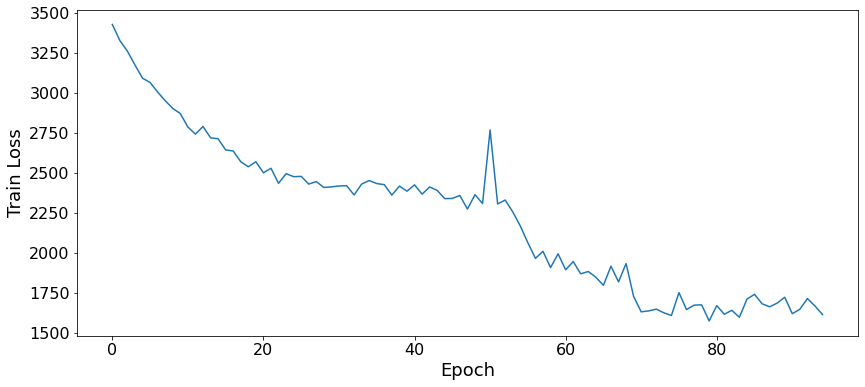

In [242]:
lo=[]
no_batches=int(len(losses_overall)/95)
for i in range(95):
  lo.append(sum(losses_overall[i*no_batches:(i+1)*no_batches]))
plot(lo)